# OPT 7 - Projet : Sentiment Analysis for Tweets

**Théo Cornille - Mirwaisse Djanbaz - Luc Gibaud - Cédric des Lauriers**

### Dataset : Sentiment dataset with 1.6 million tweets

"According to the creators of the dataset:

"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like 🙂, were positive, and tweets with negative emoticons, like 😞, were negative. We used the Twitter Search API to collect these tweets by using keyword search"

citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12

## Présentation

Nous disposons de 1.6 millions de tweets qui ont été extraits en utilisant l'API de Twitter. Ces tweets ont été annotés (0 = tweet négatif, 4 = tweet positif).

Notre objectif est d'utiliser cette base de données afin de pouvoir prédir automatiquement le sentiment qu'un auteur a voulu donner à son tweet.
Pour information, les tweets de ce dataset sont quelconques et ont été relevés sur une période de 2 mois.

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category =RuntimeWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)

In [3]:
import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from utils import *
import re

from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional, SimpleRNN, GRU
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## I. Import et exploration de la base de données

In [280]:
filepath = r"D:\Data\TWEET DATA\training.1600000.processed.noemoticon.csv"

In [281]:
df = pd.read_csv(filepath, encoding = "ISO-8859-1", header = None, names = ["target", "id", "date", "flag", "user", "text"])

In [282]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


La colonne "target" n'est composé que de 0 (=tweet négatif) et de 4 (=tweet positif). Afin de simplifier nous allons transformer les 4 et 1. Nous gardons donc:

- 0 =tweet négatif
- 1 = tweet positif

In [283]:
df.target = df.target.replace(4, 1)

In [284]:
df = df.iloc[:, [5, 0]]

In [285]:
df.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",0
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,0
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",0


In [286]:
pd.set_option('display.max_colwidth', -1)

In [287]:
df['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1    is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    
2    @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          
3    my whole body feels itchy and like its on fire                                                                     
4    @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     
Name: text, dtype: object

In [288]:
df['target'].value_counts()

1    800000
0    800000
Name: target, dtype: int64

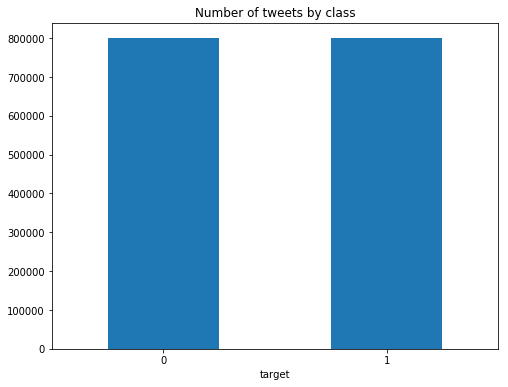

In [289]:
df.groupby(['target']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class')
plt.show()

## II. Preprocessing des données

Text Cleaning

In [290]:
class TextCleaner(BaseEstimator, TransformerMixin):    
    def remove_mentions(self, text):        
        return re.sub(r'@\w+', '', text)
    
    def remove_urls(self, text):        
        return re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    def only_characters(self, text):
        return re.sub('[^a-zA-Z\s]', '', text)
    
    def remove_extra_spaces(self, text):
        text = re.sub("\s+", ' ', text)
        text = text.lstrip()
        return text.rstrip()
    
    def to_lower(self, text):
        return text.lower()
    
    def fix_words(self, text):
        #text = re.sub(r'\bthx\b', 'thanks', text)
        pass
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):        
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.only_characters).apply(self.remove_extra_spaces).apply(self.to_lower)
        return clean_X

In [291]:
tc = TextCleaner()
df['clean_text'] = tc.transform(df['text'])

In [292]:
df.head()

,text,target,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",0,awww thats a bummer you shoulda got david carr of third day to do it d
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,0,is upset that he cant update his facebook by texting it and might cry as a result school today also blah
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0,i dived many times for the ball managed to save the rest go out of bounds
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",0,no its not behaving at all im mad why am i here because i cant see you all over there


Tokenizer

In [293]:
def tokenize(s): 
    return s.split()

In [294]:
df['tokenized'] = df['clean_text'].apply(lambda row: tokenize(row))

In [295]:
#df = df.sample(frac=1)
#df = df.reset_index(drop=True)

In [296]:
df.head()

,text,target,clean_text,tokenized
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",0,awww thats a bummer you shoulda got david carr of third day to do it d,"[awww, thats, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]"
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,0,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,"[is, upset, that, he, cant, update, his, facebook, by, texting, it, and, might, cry, as, a, result, school, today, also, blah]"
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0,i dived many times for the ball managed to save the rest go out of bounds,"[i, dived, many, times, for, the, ball, managed, to, save, the, rest, go, out, of, bounds]"
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its, on, fire]"
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",0,no its not behaving at all im mad why am i here because i cant see you all over there,"[no, its, not, behaving, at, all, im, mad, why, am, i, here, because, i, cant, see, you, all, over, there]"


remove stopwords

In [297]:
#nltk.download('stopwords')

In [298]:
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

In [299]:
def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [300]:
df['tokenized'] = df['tokenized'].apply(lambda row: remove_stopwords(row))

In [301]:
pd.set_option('display.max_colwidth', -1)

In [302]:
df[['text', 'tokenized']].head()

,text,tokenized
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D","[awww, thats, bummer, shoulda, got, david, carr, third, day]"
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,"[upset, cant, update, facebook, texting, might, cry, result, school, today, also, blah]"
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,"[dived, many, times, ball, managed, save, rest, go, bounds]"
3,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]"
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.","[no, not, behaving, im, mad, cant, see]"


### Création du vocabulaire

In [303]:
def update_vocab_counter(row):
    for word in row:
        vocab_counter[word] += 1

In [304]:
vocab_counter = collections.Counter()
df['tokenized'].apply(update_vocab_counter);
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)

In [305]:
len(vocab)

421400

In [306]:
import operator
words_count = sorted(vocab_counter.items(), key=operator.itemgetter(1), reverse=True)

In [307]:
rank=[]
frequency=[]
for i, c in enumerate(words_count):
    rank.append(i)
    frequency.append(c[1])

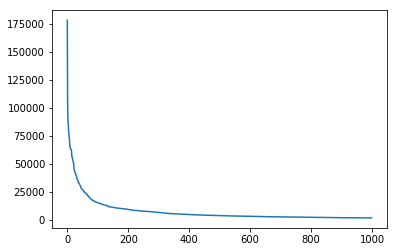

In [308]:
plt.plot(rank[:1000], frequency[:1000])
plt.show()

In [309]:
#top 1000 des tokens les plus fréquents
print(vocab[:1000])

['im', 'not', 'good', 'day', 'get', 'like', 'no', 'go', 'dont', 'today', 'going', 'love', 'cant', 'work', 'got', 'time', 'back', 'lol', 'u', 'one', 'know', 'really', 'see', 'well', 'still', 'want', 'new', 'night', 'think', 'thanks', 'home', 'oh', 'much', 'miss', 'need', 'last', 'morning', 'hope', 'great', 'tomorrow', 'ill', 'twitter', 'thats', 'haha', 'feel', 'sad', 'fun', 'wish', 'right', 'didnt', 'sleep', 'bad', 'would', 'happy', 'sorry', 'tonight', 'come', 'make', 'getting', 'way', 'gonna', 'though', 'ive', 'nice', 'better', 'watching', 'wait', 'could', 'yeah', 'bed', 'week', 'youre', 'people', 'school', 'hate', 'days', 'even', 'hey', 'next', 'weekend', 'yes', 'awesome', 'never', 'thank', 'soon', 'take', 'little', 'long', 'first', 'working', 'wanna', 'say', 'best', 'please', 'show', 'tired', 'sick', 'watch', 'everyone', 'ok', 'wont', 'life', 'done', 'feeling', 'sure', 'always', 'friends', 'already', 'thing', 'another', 'x', 'us', 'find', 'cool', 'something', 'guys', 'ready', 'made',

In [310]:
#On limite la taille du dictionnaire aux 100000 tokens les plus fréquents
max_words = 100000

In [311]:
#Dictionnaire qui map les tokens avec leur ID.

In [312]:
w2id = {w:i for i, w in enumerate(vocab[:max_words])}

In [313]:
#On remplace les autres tokens par unk

In [314]:
w2id['unk'] = -1

In [315]:
def transform_to_ids(row):
    return [w2id[w] if w in w2id else w2id['unk'] for w in row]

In [316]:
df['tokenized_int'] = df['tokenized'].apply(lambda x: transform_to_ids(x))

In [317]:
pd.set_option('display.max_colwidth', -1)

In [318]:
df[['text', 'tokenized', 'tokenized_int']].head()

,text,tokenized,tokenized_int
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D","[awww, thats, bummer, shoulda, got, david, carr, third, day]","[354, 42, 1090, 3302, 14, 752, 9647, 1728, 3]"
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,"[upset, cant, update, facebook, texting, might, cry, result, school, today, also, blah]","[662, 12, 432, 436, 1883, 190, 416, 2157, 73, 9, 169, 1068]"
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,"[dived, many, times, ball, managed, save, rest, go, bounds]","[70063, 211, 247, 1210, 1497, 780, 361, 7, 22254]"
3,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]","[319, 702, 369, 2747, 5, 1047]"
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.","[no, not, behaving, im, mad, cant, see]","[6, 1, 10232, 0, 480, 12, 22]"


## Naive Bayes

A la place d'utiliser juste la fréquence des termes, on choisit d'utiliser tf-idf pour apporter plus de justesse dans notre classification
On peut également vectoriser en bi-gramme, tri-gramme.

**Split dataset into train and valid**

Tf-idf

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.75, min_df=3, sublinear_tf=True)

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(df['clean_text'].values, df['target'].values, test_size=0.20, random_state=42)

In [48]:
tfidf_train = vect.fit_transform(X_train)
tfidf_valid = vect.transform(X_valid)

In [52]:
def naive_bayes(x, y):
    r = []; b = []
    labels = np.unique(y)

    for l in labels:
        other_l = labels[labels != l]
        p = x[y == l].sum(0) + 1 #sum of tfidf vectors of label = 1
        q = x[y == other_l].sum(0) + 1 #sum of tfidf vectors of label = 0
        r.append(np.log((p/p.sum())/(q/q.sum()))) #log ratio
        b.append(np.log(len(p)/len(q))) #ratio of positive and negative
    
    return r, b

In [53]:
r, b = naive_bayes(tfidf_train, y_train)

pre_preds = []
for j in range(len(r)):
    pre_preds.append(np.asarray(tfidf_valid @ r[j].T + b[j]).reshape(-1))
arr = np.array(pre_preds)

In [54]:
metrics.accuracy_score(y_valid, np.argmax(arr.T, axis=1))

0.804346875

In [55]:
print(metrics.classification_report(y_valid, np.argmax(arr.T, axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81    159635
           1       0.82      0.79      0.80    160365

   micro avg       0.80      0.80      0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



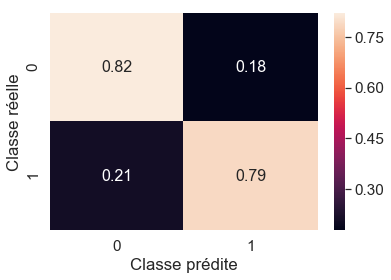

In [56]:
array = metrics.confusion_matrix(y_valid, np.argmax(arr.T, axis=1))
array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(array, range(2),range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()

## Logistic Regression

In [92]:
model = LogisticRegression()
model.fit(tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [75]:
preds = model.predict(tfidf_valid)
accuracy = (preds == y_valid).mean()
print('accuracy:', accuracy)

accuracy: 0.82303125


In [76]:
print(metrics.classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82    159494
           1       0.82      0.83      0.83    160506

   micro avg       0.82      0.82      0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



**Visualisation des tokens**

In [93]:
def get_tokens_coefs(vocab, coefs, n):
    coef_df = pd.DataFrame({'vocab': vocab, 'coef':coefs.reshape(-1)})
    return coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:n]

In [94]:
def plot_tokens_coefs(df, ax, label):
    df.sort_values('coef').plot.barh(legend=False, ax=ax)
    ax.set_yticklabels(df['vocab'].values.tolist()[::-1])
    ax.set_title(label);

In [95]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sn.set_style(style='white')

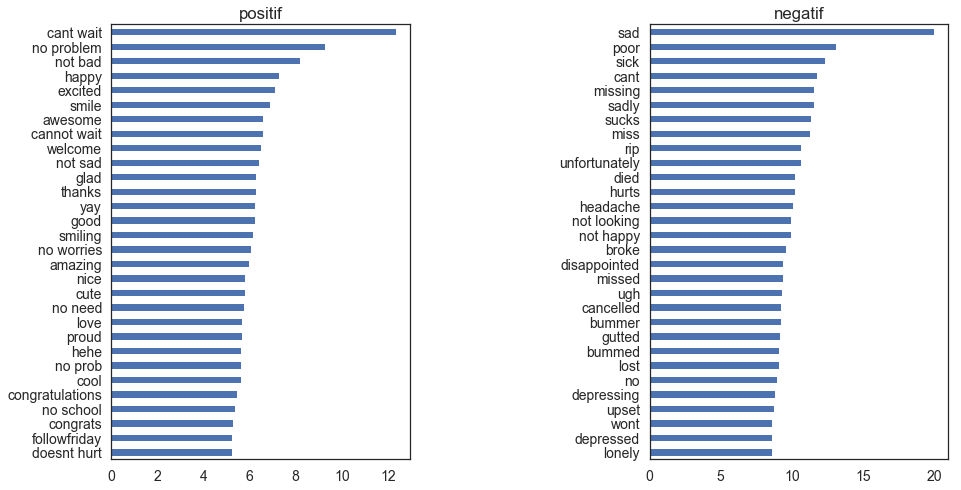

In [108]:
vocab = vect.get_feature_names()
n_coefs = 30

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.subplots_adjust(wspace=0.8)

coef_df = get_tokens_coefs(vocab, model.coef_, n_coefs)
plot_tokens_coefs(coef_df, axs[0], 'positif')

coef_df = get_tokens_coefs(vocab, 1-model.coef_, n_coefs)
plot_tokens_coefs(coef_df, axs[1], 'negatif')

## Linear model

Train - Test split

In [348]:
X_train, X_valid, y_train, y_valid = train_test_split(df['tokenized_int'].values, df['target'].values, test_size=0.25, random_state=0)

Nous allons créé un réseau de neurones avec une couche embedding de dimension 100 comme input et aucune couche cachée.
C'est équivalent à appliquer une régression logistique sur les vecteurs mots au lieu de l'appliquer aux vecteurs 1hot

In [58]:
def baseline_model():
    model = Sequential([Embedding(input_dim=max_words, output_dim=50, input_length=maxlen),
                        Flatten(),
                        Dense(2, activation='sigmoid')])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

Pour ce modèle, les vecteurs mots ont besoin d'être de taille fixé

- limitation de la longueur d'un tweet

In [349]:
lens = df['tokenized_int'].apply(lambda x: len(x))

In [60]:
min(lens), max(lens), np.mean(lens)

(0, 35, 7.239204375)

In [321]:
maxlen = 10

On choisit donc une longueur de tweet maximale de 10

On remplit les vecteurs/phrases de taille inférieure à 10 avec des -1 (représentant les mot de type 'unk').

In [350]:
x_train = pad_sequences(X_train, maxlen=maxlen, value=-1)
x_valid = pad_sequences(X_valid, maxlen=maxlen, value=-1)

On encode les classes en 1hot vector:

In [351]:
hot_y = np_utils.to_categorical(y_train)
hot_y_valid = np_utils.to_categorical(y_valid)

model training

In [65]:
model = baseline_model()
baseline_history = model.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/5
1200000/1200000 [==============================] - 88s 73us/step - loss: 0.4737 - acc: 0.7801 - val_loss: 0.4606 - val_acc: 0.7889
Epoch 2/5
1200000/1200000 [==============================] - 85s 71us/step - loss: 0.4343 - acc: 0.8048 - val_loss: 0.4670 - val_acc: 0.7857
Epoch 3/5
1200000/1200000 [==============================] - 85s 71us/step - loss: 0.4024 - acc: 0.8227 - val_loss: 0.4856 - val_acc: 0.7782
Epoch 4/5
1200000/1200000 [==============================] - 85s 71us/step - loss: 0.3783 - acc: 0.8357 - val_loss: 0.5066 - val_acc: 0.7730
Epoch 5/5
1200000/1200000 [==============================] - 85s 71us/step - loss: 0.3620 - acc: 0.8438 - val_loss: 0.5245 - val_acc: 0.7682


In [ ]:
acc = baseline_history.history['acc']
val_acc = baseline_history.history['val_acc']
loss= baseline_history.history['loss']
val_loss= baseline_history.history['val_loss']

In [ ]:
num_epochs=range(1,len(loss)+1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(num_epochs, acc, 'bo', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Convolutional Neural Network

Nous allons créé un réseau de neurones convolutionel très simple. Il dispose d'une couche de convolution (10 filtres de taille 3).

In [73]:
def conv_model():
    model = Sequential([Embedding(input_dim=max_words, output_dim=32, input_length=maxlen),
                        Convolution1D(10, 3, padding='same', activation='relu'),
                        MaxPooling1D(),
                        Flatten(),
                        Dense(50, activation='relu'),
                        Dense(2, activation='sigmoid')])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [74]:
convmodel = conv_model()
convmodel.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/5
1200000/1200000 [==============================] - 71s 60us/step - loss: 0.4402 - acc: 0.7940 - val_loss: 0.4175 - val_acc: 0.8076
Epoch 2/5
1200000/1200000 [==============================] - 72s 60us/step - loss: 0.3866 - acc: 0.8254 - val_loss: 0.4160 - val_acc: 0.8097
Epoch 3/5
1200000/1200000 [==============================] - 72s 60us/step - loss: 0.3512 - acc: 0.8442 - val_loss: 0.4274 - val_acc: 0.8058
Epoch 4/5
1200000/1200000 [==============================] - 73s 61us/step - loss: 0.3197 - acc: 0.8608 - val_loss: 0.4531 - val_acc: 0.7991
Epoch 5/5
1200000/1200000 [==============================] - 72s 60us/step - loss: 0.2937 - acc: 0.8734 - val_loss: 0.4749 - val_acc: 0.7964


In [78]:
training_loss_value, training_acc_value = convmodel.evaluate(x_train, hot_y, batch_size=100)
valid_loss_value, valid_acc_value = convmodel.evaluate(x_valid, hot_y_valid, batch_size=100)

400000/400000 [==============================] - 4s 10us/step


In [79]:
print('training loss : {:.4f}'.format(training_loss_value))
print('validation_loss : {:.4f}'.format(valid_loss_value))
print(' ')
print('training accuracy : {:.2f} %'.format(100*training_acc_value))
print('validation accuracy : {:.2f} %'.format(100*valid_acc_value))

training loss : 0.2526
validation_loss : 0.4749
 
training accuracy : 89.57 %
validation accuracy : 79.64 %


Nous allons maintenant créé un réseau de neurones convolutionnel un peu plus complexe qui appliquent différents tailles de filtres (taille 2, 3 et 4).

In [80]:
def mult_conv():
    graph_in = Input(shape=(max_words, 50))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(64, filter_size, padding='same', activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)
    
    model = Sequential([Embedding(max_words, 50, input_length=maxlen),
                    graph,
                    Dropout(0.5),
                    Dense(25, activation='relu'),
                    Dense(2, activation='sigmoid')])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [81]:
multconv = mult_conv() 
multconv_history = multconv.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/3
1200000/1200000 [==============================] - 96s 80us/step - loss: 0.4535 - acc: 0.7873 - val_loss: 0.4254 - val_acc: 0.8047
Epoch 2/3
1200000/1200000 [==============================] - 95s 79us/step - loss: 0.4066 - acc: 0.8155 - val_loss: 0.4208 - val_acc: 0.8070
Epoch 3/3
1200000/1200000 [==============================] - 95s 79us/step - loss: 0.3809 - acc: 0.8298 - val_loss: 0.4200 - val_acc: 0.8067


In [82]:
acc = multconv_history.history['acc']
val_acc = multconv_history.history['val_acc']
loss = multconv_history.history['loss']
val_loss = multconv_history.history['val_loss']

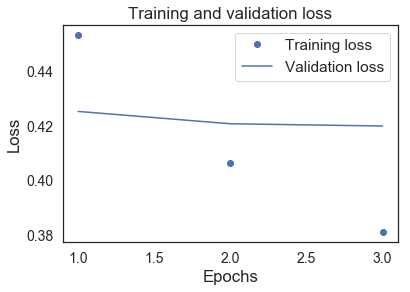

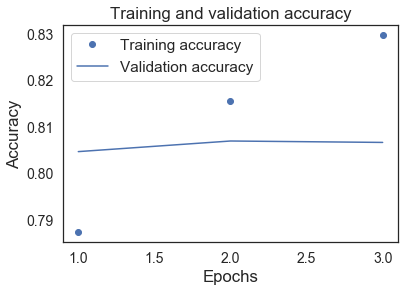

In [83]:
num_epochs=range(1,len(loss)+1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(num_epochs, acc, 'bo', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [85]:
training_loss_value, training_acc_value = multconv.evaluate(x_train, hot_y, batch_size=100)
valid_loss_value, valid_acc_value = multconv.evaluate(x_valid, hot_y_valid, batch_size=100)

400000/400000 [==============================] - 4s 10us/step


In [86]:
print('training loss : {:.4f}'.format(training_loss_value))
print('validation_loss : {:.4f}'.format(valid_loss_value))
print(' ')
print('training accuracy : {:.2f} %'.format(100*training_acc_value))
print('validation accuracy : {:.2f} %'.format(100*valid_acc_value))

training loss : 0.3429
validation_loss : 0.4200
 
training accuracy : 85.34 %
validation accuracy : 80.67 %


## SimpleRNN

In [94]:
def simple_rnn():
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=maxlen))
    model.add(SimpleRNN(32))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [95]:
simplernn = simple_rnn() 
simplernn_history = simplernn.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=1, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/1
1200000/1200000 [==============================] - 231s 192us/step - loss: 0.4559 - acc: 0.7858 - val_loss: 0.4308 - val_acc: 0.8023


## LSTM

- couteux en temps computationnel mais très bon en représentation

In [96]:
def simple_lstm():
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=maxlen))
    model.add(LSTM(32))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [98]:
simplelstm = simple_lstm() 
simplelstm_history = simplelstm.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=1, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/1
1200000/1200000 [==============================] - 431s 359us/step - loss: 0.4403 - acc: 0.7947 - val_loss: 0.4189 - val_acc: 0.8060


## GRU

- similaire au lstm
- compromis en temps computationnel et représentation

In [100]:
def simple_gru():
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=maxlen))
    model.add(GRU(32))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [101]:
simplegru = simple_gru() 
simplegru_history = simplegru.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=1, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/1
1200000/1200000 [==============================] - 375s 313us/step - loss: 0.4408 - acc: 0.7947 - val_loss: 0.4144 - val_acc: 0.8094


## BI LSTM

Pas très utile mais à tester quand même

In [70]:
def bidirectional_gru():
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=maxlen))
    model.add(Bidirectional(GRU(32)))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [71]:
bidirectionalgru = bidirectional_gru() 
bidirectionalgru_history = bidirectionalgru.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=1, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/1
1200000/1200000 [==============================] - 338s 282us/step - loss: 0.4488 - acc: 0.7892 - val_loss: 0.4280 - val_acc: 0.8017


# Modèle final choisi

Nous allons donc choisir le modèle le plus performant en temps computationnel et pouvoir de représentation.

Au vu de nos données, tweets de taille assez courts (moyenne de mots dans un tweet = 8), nous choisissons donc un réseau de neurones convolutionnel

### Pre-trained word embeddings

Nous allons utiliser un modèle pré-entrainé à l'aide de GloVe pour améliorer notre modèle.

Nous allons utilisé des words vectors pré-entrainé.

Nous téléchargeons le fichier suivant:
- Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip

url : https://nlp.stanford.edu/projects/glove/

In [325]:
glove_dir = 'D:\Data\TWEET DATA'

In [326]:
embeddings_index = {}
f = open(glove_dir + '\glove.twitter.27B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [327]:
len(embeddings_index)

1193514

In [328]:
def create_embedding_matrix(max_words, embedding_dim):
    embedding_matrix = np.zeros((max_words, embedding_dim))
    found = 0
    for word, i in w2id.items():
        embedding_vector = embeddings_index.get(word)
        if i < max_words:
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                found += 1
            else:
                embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return embedding_matrix, found

In [329]:
embedding_matrix, found = create_embedding_matrix(max_words, 100)

In [330]:
found

72406

## CNN

In [79]:
def cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=32, input_length=maxlen))
    model.add(Convolution1D(10, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    model.layers[0].set_weights = [embedding_matrix]
    model.layers[0].trainable = True

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [80]:
cnn = cnn_model() 
cnn_history = cnn.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/5
1200000/1200000 [==============================] - 78s 65us/step - loss: 0.4486 - acc: 0.7889 - val_loss: 0.4278 - val_acc: 0.8016
Epoch 2/5
1200000/1200000 [==============================] - 77s 64us/step - loss: 0.3953 - acc: 0.8203 - val_loss: 0.4275 - val_acc: 0.8032
Epoch 3/5
1200000/1200000 [==============================] - 77s 64us/step - loss: 0.3594 - acc: 0.8395 - val_loss: 0.4388 - val_acc: 0.7990
Epoch 4/5
1200000/1200000 [==============================] - 76s 64us/step - loss: 0.3277 - acc: 0.8563 - val_loss: 0.4598 - val_acc: 0.7956
Epoch 5/5
1200000/1200000 [==============================] - 76s 64us/step - loss: 0.3013 - acc: 0.8690 - val_loss: 0.4828 - val_acc: 0.7882


In [81]:
acc = cnn_history.history['acc']
val_acc = cnn_history.history['val_acc']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

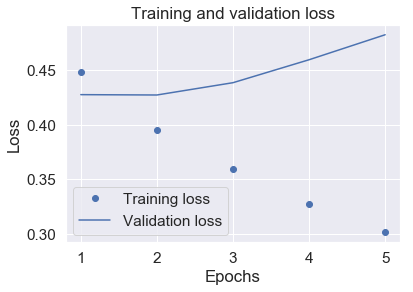

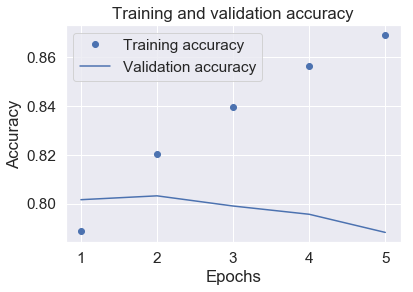

In [82]:
num_epochs=range(1,len(loss)+1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(num_epochs, acc, 'bo', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [83]:
training_loss_value, training_acc_value = cnn.evaluate(x_train, hot_y, batch_size=100)
valid_loss_value, valid_acc_value = cnn.evaluate(x_valid, hot_y_valid, batch_size=100)

400000/400000 [==============================] - 5s 12us/step


In [84]:
print('training loss : {:.4f}'.format(training_loss_value))
print('validation_loss : {:.4f}'.format(valid_loss_value))
print(' ')
print('training accuracy : {:.2f} %'.format(100*training_acc_value))
print('validation accuracy : {:.2f} %'.format(100*valid_acc_value))

training loss : 0.2606
validation_loss : 0.4828
 
training accuracy : 89.23 %
validation accuracy : 78.82 %


On voit que notre CNN overfit beaucoup trop, il faudra donc essayer de rajouter de la régularisation (comme du dropout par exemple).

# Transfer Learning, Topic modeling et Analyse de tweets en temps réel

In [323]:
def mult_conv_glove():
    graph_in = Input(shape=(max_words, 100))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(64, filter_size, padding='same', activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)
    
    model = Sequential([Embedding(max_words, 100,weights=[embedding_matrix],  input_length=maxlen, trainable=True ),
                    graph,
                    Dropout(0.5),
                    Dense(25, activation='relu'),
                    Dense(2, activation='sigmoid')])
    
    
   
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [333]:
# moins tendance à overfit quand trainable = False 
cnn_glove = mult_conv_glove()

## cnn_glove est le modèle qu'on va utliser pour le transfer learning et pour l'analyse de tweet en temps réel

Rq : Dans la suite on va utliser le modèle cnn_glove avec des embeddings de glove qu'on a modifié lors de l'entrainement (trainable = true) pour l'exemple, pour autant il peut être judicieux de les fixer quand on entraine cnn_glove pour avoir une meilleur généalisation lors du tranfert

In [352]:
# moins tendance à overfit quand trainable = False 
cnn_history = cnn_glove.fit(x_train, hot_y, validation_data=(x_valid, hot_y_valid), epochs=5, batch_size=100)

Train on 1200000 samples, validate on 400000 samples
Epoch 1/5
1200000/1200000 [==============================] - 149s 124us/step - loss: 0.4596 - acc: 0.7829 - val_loss: 0.4313 - val_acc: 0.801010s - loss: 0.4612 -  - ETA:  - ETA: 5s - loss: 0.4604 - - ETA: 4s - loss: 0.4603 - - E - ETA: 1s - loss: 0.4599  - ETA: 1s - loss: 0.
Epoch 2/5
1200000/1200000 [==============================] - 146s 122us/step - loss: 0.4194 - acc: 0.8073 - val_loss: 0.4242 - val_acc: 0.8043ss: 0.4194 - a
Epoch 3/5
1200000/1200000 [==============================] - 148s 124us/step - loss: 0.4004 - acc: 0.8184 - val_loss: 0.4276 - val_acc: 0.8052
Epoch 4/5
1200000/1200000 [==============================] - 148s 123us/step - loss: 0.3837 - acc: 0.8274 - val_loss: 0.4251 - val_acc: 0.8041: 0.3830 - acc: 0.82 - ETA: 10s - loss: 0.3830 - - ETA: 1 - ETA:  - ETA: 6s - loss: 0.3833 - ETA: 5s - ETA: 3s - ETA: 2s -  - ETA: 0s - loss: 0.3836 - 
Epoch 5/5
1200000/1200000 [==============================] - 147s 123us/step

# Transfer learning 

Pour tester le transfer learning, nous avons choisi un second dataset : tweets_airline qui contient 15 000 tweets de clients de compagnies aériennes américaines.
Le dataset contient ainsi peu de données.

Quand on a peu de données avec tweet airline le transfer est bénéfique pour l'apprentissage.
Le transfer prévient du sur apprentissage du modèle.

Pour procéder au transfer : 
- On entraîne un modèle au préalable : ici cnn_glove un réseau multicouche de convolution avec des Embeddings pré-entrainé (cf ci dessus),  déterminer si on fixe ou non les poids des embeddings lors l'entrainement de cnn_glove (a priori mieux de les laisser fixé pour une meilleur généralisation )

- On fixe les poids des premières couches de cnn_glove (features obtenues à l'aide de la base de tweet initiale )

- On enlève (dans notre cas ) les 2 dernières couches dense et on les remplace (au choix ) par 2 couches de dropout et de dense pour les adapter au nouveau problème de classification du transfert (ici aussi 2 classes )  

Rq : on applique bien évidement le même préprocessing sur les nouvelles données 

In [91]:
# Freeze the layers except the last 2 layers
# on va enlever les 2 dernirère couches dense pour appliquer le transfer ensuite
for layer in cnn_glove.layers[:-2]:
    layer.trainable = False
 
 
# Check the trainable status of the individual layers
for layer in cnn_glove.layers:
    print(layer, layer.trainable)

<keras.layers.embeddings.Embedding object at 0x0000014EEB542A20> False
<keras.engine.training.Model object at 0x0000014EEB55B588> False
<keras.layers.core.Dropout object at 0x0000014EEB542710> False
<keras.layers.core.Dense object at 0x0000014EEB557898> True
<keras.layers.core.Dense object at 0x0000014EEB557630> True


In [145]:
Tweet_airline= pd.read_csv(r"C:\Users\MyPC\Documents\AIC-partage\Structured\data\Tweets.csv")
Tweet_airline= Tweet_airline[Tweet_airline.airline_sentiment !="neutral"]
Tweet_airline = Tweet_airline[["text", "airline_sentiment"]]

# on ne garde qu'une petite partie : pour voir l'interet du transfer learning  
Tweet_airline = Tweet_airline.sample(frac=1)
Tweet_airline = Tweet_airline[:100]

Tweet_airline.head()

,text,airline_sentiment
6359,@SouthwestAir flight at 630 from fll kiosk just opened. Rude attendants because now everyone is Late Flight. http://t.co/2Boh2Mh3cb,negative
7045,I hate you all. RT @JetBlue: Our fleet's on fleek. http://t.co/uTdfqF5WPA,negative
6738,@SouthwestAir flight was Cancelled Flightled and it won't let me rebook online. Wait time on phone is too long. Please help,negative
12189,"@AmericanAir \nNot giving you a hard time...Just looking for basic customer service after AA lost my bag. ETA on it's return, please????????",negative
793,"@united for an early flt, I think a call is appropriate. Yes, reviewed and nada avail until next day. Expect full refund",negative


In [146]:
df2 = Tweet_airline
df2['clean_text'] = tc.transform(df2['text'])
df2['tokenized'] = df2['clean_text'].apply(lambda row: tokenize(row))
df2['tokenized'] = df2['tokenized'].apply(lambda row: remove_stopwords(row))
df2['tokenized_int'] = df2['tokenized'].apply(lambda x: transform_to_ids(x))
sentiment_dict = {'positive': 1, 'negative':0 } 
df2['sentiment'] = [sentiment_dict[item] for item in Tweet_airline.airline_sentiment] 
df2.head()

,text,airline_sentiment,clean_text,tokenized,tokenized_int,sentiment
6359,@SouthwestAir flight at 630 from fll kiosk just opened. Rude attendants because now everyone is Late Flight. http://t.co/2Boh2Mh3cb,negative,flight at from fll kiosk just opened rude attendants because now everyone is late flight,"[flight, fll, kiosk, opened, rude, attendants, everyone, late, flight]","[668, 0, 0, 2378, 2177, 0, 104, 208, 668]",0
7045,I hate you all. RT @JetBlue: Our fleet's on fleek. http://t.co/uTdfqF5WPA,negative,i hate you all rt our fleets on fleek,"[hate, fleets, fleek]","[73, 0, 0]",0
6738,@SouthwestAir flight was Cancelled Flightled and it won't let me rebook online. Wait time on phone is too long. Please help,negative,flight was cancelled flightled and it wont let me rebook online wait time on phone is too long please help,"[flight, cancelled, flightled, wont, let, rebook, online, wait, time, phone, long, please, help]","[668, 1184, 0, 101, 137, 0, 422, 68, 16, 122, 86, 90, 143]",0
12189,"@AmericanAir \nNot giving you a hard time...Just looking for basic customer service after AA lost my bag. ETA on it's return, please????????",negative,not giving you a hard timejust looking for basic customer service after aa lost my bag eta on its return please,"[not, giving, hard, timejust, looking, basic, customer, service, aa, lost, bag, eta, return, please]","[1, 878, 196, 0, 114, 4782, 2529, 819, 0, 140, 1067, 0, 1180, 90]",0
793,"@united for an early flt, I think a call is appropriate. Yes, reviewed and nada avail until next day. Expect full refund",negative,for an early flt i think a call is appropriate yes reviewed and nada avail until next day expect full refund,"[early, flt, think, call, appropriate, yes, reviewed, nada, avail, next, day, expect, full, refund]","[158, 0, 28, 236, 4503, 82, 0, 0, 0, 79, 3, 1937, 384, 0]",0


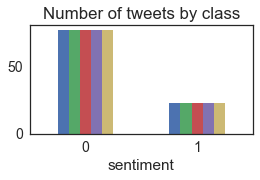

In [147]:
df2.groupby(['sentiment']).count().plot(kind='bar', figsize=(4, 2), rot=0, legend=False, title='Number of tweets by class')
plt.show()

In [148]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(df2['tokenized_int'].values, df2['sentiment'].values, test_size=0.25, random_state=0)
x_train_2 = pad_sequences(X_train_2, maxlen=maxlen, value=0)
x_valid_2 = pad_sequences(X_valid_2, maxlen=maxlen, value=0)
hot_y_2 = np_utils.to_categorical(y_train_2)
hot_y_valid_2 = np_utils.to_categorical(y_valid_2)

In [163]:
x_train.shape

(150000, 10)

In [149]:
cnn_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 10, 50)            250000    
_________________________________________________________________
model_2 (Model)              (None, 64)                28992     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 25)                1625      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 52        
Total params: 559,661
Trainable params: 280,669
Non-trainable params: 278,992
_________________________________________________________________


D:\Programmes\Anaconda2\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [151]:
from keras import models
from keras import layers
from keras import optimizers

def transfer_model(pretrained_model ): 
    # Create the model
    model = models.Sequential()

    # Add the first layers of the trained model :keep the output of the k_ième layer 
    # Ici on enlève les 2 dernières couches dense_11 et dense_12
    model.add(Model(inputs=pretrained_model.get_input_at(0) ,outputs=pretrained_model.get_layer("dropout_4").get_output_at(0)))
    #model.add(pretrained_model)  à la place de la ligne du dessus si pas besoin d'enlever les dernières couches 

    # Add new layers
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    
    return model
    
    

In [152]:
trans_model = transfer_model(cnn_glove )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_12 (Model)             (None, 64)                278992    
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                3250      
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 102       
Total params: 282,344
Trainable params: 3,352
Non-trainable params: 278,992
_________________________________________________________________
None


In [157]:
# avec transfer 
essai = trans_model.fit(x_train_2, hot_y_2, validation_data=(x_valid_2, hot_y_valid_2), epochs=10, batch_size=20)

Train on 75 samples, validate on 25 samples
Epoch 1/10
75/75 [==============================] - 0s 319us/step - loss: 0.4310 - acc: 0.8000 - val_loss: 0.2475 - val_acc: 0.9600
Epoch 2/10
75/75 [==============================] - 0s 199us/step - loss: 0.3631 - acc: 0.8333 - val_loss: 0.2463 - val_acc: 0.9600
Epoch 3/10
75/75 [==============================] - 0s 187us/step - loss: 0.4645 - acc: 0.7600 - val_loss: 0.2463 - val_acc: 0.9600
Epoch 4/10
75/75 [==============================] - 0s 186us/step - loss: 0.4973 - acc: 0.7467 - val_loss: 0.2473 - val_acc: 0.9600
Epoch 5/10
75/75 [==============================] - 0s 199us/step - loss: 0.4031 - acc: 0.8000 - val_loss: 0.2475 - val_acc: 0.9600
Epoch 6/10
75/75 [==============================] - 0s 199us/step - loss: 0.3621 - acc: 0.8467 - val_loss: 0.2462 - val_acc: 0.9600
Epoch 7/10
75/75 [==============================] - 0s 199us/step - loss: 0.4091 - acc: 0.8200 - val_loss: 0.2448 - val_acc: 0.9600
Epoch 8/10
75/75 [==============

In [158]:
# sans transfer 
cnn_glove1 = mult_conv_glove()
essai2 = cnn_glove1.fit(x_train_2, hot_y_2, validation_data=(x_valid_2, hot_y_valid_2), epochs=10, batch_size=20)


Train on 75 samples, validate on 25 samples
Epoch 1/10
75/75 [==============================] - 1s 17ms/step - loss: 1.0412 - acc: 0.3600 - val_loss: 0.5947 - val_acc: 0.6800
Epoch 2/10
75/75 [==============================] - 0s 598us/step - loss: 0.7583 - acc: 0.5133 - val_loss: 0.4574 - val_acc: 0.8800
Epoch 3/10
75/75 [==============================] - 0s 798us/step - loss: 0.6169 - acc: 0.6600 - val_loss: 0.4108 - val_acc: 0.8800
Epoch 4/10
75/75 [==============================] - 0s 838us/step - loss: 0.5859 - acc: 0.7133 - val_loss: 0.3818 - val_acc: 0.8800
Epoch 5/10
75/75 [==============================] - 0s 851us/step - loss: 0.4927 - acc: 0.7600 - val_loss: 0.3666 - val_acc: 0.8800
Epoch 6/10
75/75 [==============================] - 0s 811us/step - loss: 0.5611 - acc: 0.7200 - val_loss: 0.3560 - val_acc: 0.8800
Epoch 7/10
75/75 [==============================] - 0s 837us/step - loss: 0.5794 - acc: 0.6867 - val_loss: 0.3522 - val_acc: 0.8800
Epoch 8/10
75/75 [===============

# Topic Modeling (LDA) on Airline tweets

On reprend maintenant le dataset que nous avons utiliser pour effectuer du transfer learning.
Pour rappel, le dataset est un dataset de tweets de clients de compagnies américaines de voyages. Ce dataset est pratique pour faire du topic modeling car en plus d'avoir un tweet positif ou negatif de la part du client, on a également le type de problèmes que le client a rencontré.

On peut ainsi retrouver facilement de manière non supervisée les différents "thèmes"/"types" de problèmes des clients en s'appuyant sur le dataset supervisé.
Le dataset supervisée a annoté 10 types de problèmes rencontrés que nous allons voir dans la suite.

In [11]:
#Conservation des tweets uniquement négatifs
filepath = r"D:\Data\TWEET DATA\Airline-Sentiment.csv"
Tweet_airline = pd.read_csv(filepath, encoding = "ISO-8859-1")
Tweet_airline = Tweet_airline[Tweet_airline.airline_sentiment !="neutral"]
Tweet_airline = Tweet_airline[Tweet_airline.airline_sentiment !="positive"]

In [12]:
Tweet_airline = Tweet_airline[["text", "airline_sentiment", "negativereason"]]

In [13]:
Tweet_airline.head()

,text,airline_sentiment,negativereason
3,@VirginAmerica it's really aggressive to blast...,negative,Bad Flight
4,@VirginAmerica and it's a really big bad thing...,negative,Can't Tell
5,@VirginAmerica seriously would pay $30 a fligh...,negative,Can't Tell
15,@VirginAmerica SFO-PDX schedule is still MIA.,negative,Late Flight
17,@VirginAmerica I flew from NYC to SFO last we...,negative,Bad Flight


In [14]:
#mélange du dataset
Tweet_airline = Tweet_airline.sample(frac=1)
Tweet_airline = Tweet_airline.reset_index(drop=True)

In [15]:
pd.set_option('display.max_colwidth', -1)

In [16]:
Tweet_airline['text'].head()

0    @USAirways any guesstimate on hold times? Can't change my flight online, at 45 mins and counting...                                        
1    @USAirways unfortunately patience won't get me to my boat that leaves at 4 pm. I was on hold watching all flights fill up.                 
2    @SouthwestAir okay I understand a delay one way. But both ways? C'mon #annoyed #flights                                                    
3    @USAirways your checkin at @PHLAirport is a #shitshow, and the agent behind the counter who tried to send me to the wrong destination=rude!
4    @SouthwestAir Why doesn't mean TSA PreCheck show up on my mobile boarding pass? My KTN is linked to my account.                            
Name: text, dtype: object

In [18]:
#nettoyage du texte
tc = TextCleaner()
Tweet_airline['clean_text'] = tc.transform(Tweet_airline['text'])

In [19]:
Tweet_airline[['text', 'clean_text']].head()

,text,clean_text
0,"@USAirways any guesstimate on hold times? Can't change my flight online, at 45 mins and counting...",any guesstimate on hold times cant change my flight online at mins and counting
1,@USAirways unfortunately patience won't get me to my boat that leaves at 4 pm. I was on hold watching all flights fill up.,unfortunately patience wont get me to my boat that leaves at pm i was on hold watching all flights fill up
2,@SouthwestAir okay I understand a delay one way. But both ways? C'mon #annoyed #flights,okay i understand a delay one way but both ways cmon annoyed flights
3,"@USAirways your checkin at @PHLAirport is a #shitshow, and the agent behind the counter who tried to send me to the wrong destination=rude!",your checkin at is a shitshow and the agent behind the counter who tried to send me to the wrong destinationrude
4,@SouthwestAir Why doesn't mean TSA PreCheck show up on my mobile boarding pass? My KTN is linked to my account.,why doesnt mean tsa precheck show up on my mobile boarding pass my ktn is linked to my account


Voici les 10 différents types de problèmes des compagnies aériennes:

In [20]:
Tweet_airline['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight               847 
Lost Luggage                   724 
Bad Flight                     580 
Flight Booking Problems        529 
Flight Attendant Complaints    481 
longlines                      178 
Damaged Luggage                74  
Name: negativereason, dtype: int64

On voit que tous les thèmes ne sont pas également répartis.
On va retirer pour simplifier le topic modeling, certains thèmes, difficile à catégoriser tels que le thème "Can't Tell".
On peut également s'apercevoir que les thèmes se recoupent assez facilement : les différences entre thèmes sont très minimes. Il est donc difficile de hiérarchiser ces thèmes. Certains sont des sous-thèmes de certains thèmes.
On peut par exemple associer : Damaged Luggage et Lost Luggage ensemble par simplification.


In [115]:
#suppression du thème "Can't Tell"
Tweet_airline = Tweet_airline[Tweet_airline.negativereason !="Can't Tell"]

In [116]:
Tweet_airline[['text', 'negativereason']].head(20)

,text,negativereason
0,"@USAirways any guesstimate on hold times? Can't change my flight online, at 45 mins and counting...",Customer Service Issue
1,@USAirways unfortunately patience won't get me to my boat that leaves at 4 pm. I was on hold watching all flights fill up.,Late Flight
2,@SouthwestAir okay I understand a delay one way. But both ways? C'mon #annoyed #flights,Late Flight
3,"@USAirways your checkin at @PHLAirport is a #shitshow, and the agent behind the counter who tried to send me to the wrong destination=rude!",Flight Attendant Complaints
4,@SouthwestAir Why doesn't mean TSA PreCheck show up on my mobile boarding pass? My KTN is linked to my account.,Flight Booking Problems
5,@united flight was Cancelled Flighted after the last opportunity to rebook us on other flights this evening passed.,Cancelled Flight
6,@JetBlue WHAT'S UP WITH WEBSITE CAN'T ACCESS FLIGHT INFO,Flight Booking Problems
8,@AmericanAir umm unexpected?? Unexpected meaning you guys didn't know you had a major staff shortage ??,Customer Service Issue
9,@AmericanAir the app doesn't allow Canadian address. I used the mobile Canadian site and it will not let you select a passenger.,Flight Booking Problems
10,@AmericanAir probs the worst customer service ever. Replied to complaint I submitted 6 weeks ago bout damaged bag... Not even replacing it!,Customer Service Issue


In [22]:
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
from nltk import PorterStemmer
#nltk.download('wordnet')

In [23]:
Tweet_airline['tokenized'] = Tweet_airline['clean_text'].apply(lambda row: tokenize(row))

In [118]:
Tweet_airline[['clean_text', 'tokenized']].head()

,clean_text,tokenized
0,any guesstimate on hold times cant change my flight online at mins and counting,"[any, guesstimate, on, hold, times, cant, change, my, flight, online, at, mins, and, counting]"
1,unfortunately patience wont get me to my boat that leaves at pm i was on hold watching all flights fill up,"[unfortunately, patience, wont, get, me, to, my, boat, that, leaves, at, pm, i, was, on, hold, watching, all, flights, fill, up]"
2,okay i understand a delay one way but both ways cmon annoyed flights,"[okay, i, understand, a, delay, one, way, but, both, ways, cmon, annoyed, flights]"
3,your checkin at is a shitshow and the agent behind the counter who tried to send me to the wrong destinationrude,"[your, checkin, at, is, a, shitshow, and, the, agent, behind, the, counter, who, tried, to, send, me, to, the, wrong, destinationrude]"
4,why doesnt mean tsa precheck show up on my mobile boarding pass my ktn is linked to my account,"[why, doesnt, mean, tsa, precheck, show, up, on, my, mobile, boarding, pass, my, ktn, is, linked, to, my, account]"


In [25]:
#preprocessing du texte pré-nettoyé : on tokenize, on enlève les stop-words, on lemmatize à partir de la catégorie du mot.
lemmatizer = WordNetLemmatizer()

from nltk.corpus import wordnet

tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

def get_wordnet_pos(word, tag_dict):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(token):
    return lemmatizer.lemmatize(token, get_wordnet_pos(token, tag_dict))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result

In [26]:
Tweet_airline['tokenized_preprocessed'] = Tweet_airline['clean_text'].apply(lambda row: preprocess(row))

In [27]:
Tweet_airline[['tokenized', 'tokenized_preprocessed']].head()

,tokenized,tokenized_preprocessed
0,"[any, guesstimate, on, hold, times, cant, change, my, flight, online, at, mins, and, counting]","[guesstimate, hold, time, change, flight, online, min, counting]"
1,"[unfortunately, patience, wont, get, me, to, my, boat, that, leaves, at, pm, i, was, on, hold, watching, all, flights, fill, up]","[unfortunately, patience, wont, boat, leaf, hold, watch, flight]"
2,"[okay, i, understand, a, delay, one, way, but, both, ways, cmon, annoyed, flights]","[okay, understand, delay, way, cmon, annoyed, flight]"
3,"[your, checkin, at, is, a, shitshow, and, the, agent, behind, the, counter, who, tried, to, send, me, to, the, wrong, destinationrude]","[checkin, shitshow, agent, counter, try, send, wrong, destinationrude]"
4,"[why, doesnt, mean, tsa, precheck, show, up, on, my, mobile, boarding, pass, my, ktn, is, linked, to, my, account]","[doesnt, mean, precheck, mobile, boarding, pas, link, account]"


In [28]:
#on utilise également le stemming pour rapporter les mots à une racine invariable.
stemmer = PorterStemmer()

def stemming(text):
    return [stemmer.stem(token) for token in text]

Tweet_airline['stem'] = Tweet_airline['tokenized_preprocessed'].apply(lambda row: stemming(row))

In [29]:
Tweet_airline[['tokenized', 'tokenized_preprocessed', 'stem']].head()

,tokenized,tokenized_preprocessed,stem
0,"[any, guesstimate, on, hold, times, cant, change, my, flight, online, at, mins, and, counting]","[guesstimate, hold, time, change, flight, online, min, counting]","[guesstim, hold, time, chang, flight, onlin, min, count]"
1,"[unfortunately, patience, wont, get, me, to, my, boat, that, leaves, at, pm, i, was, on, hold, watching, all, flights, fill, up]","[unfortunately, patience, wont, boat, leaf, hold, watch, flight]","[unfortun, patienc, wont, boat, leaf, hold, watch, flight]"
2,"[okay, i, understand, a, delay, one, way, but, both, ways, cmon, annoyed, flights]","[okay, understand, delay, way, cmon, annoyed, flight]","[okay, understand, delay, way, cmon, annoy, flight]"
3,"[your, checkin, at, is, a, shitshow, and, the, agent, behind, the, counter, who, tried, to, send, me, to, the, wrong, destinationrude]","[checkin, shitshow, agent, counter, try, send, wrong, destinationrude]","[checkin, shitshow, agent, counter, tri, send, wrong, destinationrud]"
4,"[why, doesnt, mean, tsa, precheck, show, up, on, my, mobile, boarding, pass, my, ktn, is, linked, to, my, account]","[doesnt, mean, precheck, mobile, boarding, pas, link, account]","[doesnt, mean, precheck, mobil, board, pa, link, account]"


In [245]:
#création du dictionnaire à partir des mots stemmatisés
dictionary = gensim.corpora.Dictionary(Tweet_airline['stem'])

In [246]:
len(dictionary)

5593

In [247]:
#on filtre le dictionnaire pour conserver les mots qui nous intéressent le plus
dictionary.filter_extremes(no_below=1, no_above=0.25, keep_n=5300)

In [248]:
len(dictionary)

5300

In [249]:
#On transforme les tweets en bag of words.
bow_corpus = [dictionary.doc2bow(tweet) for tweet in Tweet_airline['stem']]

On va maintenant chercher le nombre de thèmes qui nous assurent des différences maximales entre les thèmes. La mesure de cohérence du topic modeling va traduire une bonne représentation des thèmes dans l'espace. On fait donc varier le nombre de thèmes entre 3 et 11 et on regarde le nombre de topics qui maximise la valeur de cohérence.

In [209]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=50, workers=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [255]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=Tweet_airline['stem'], start=3, limit=11, step=1)

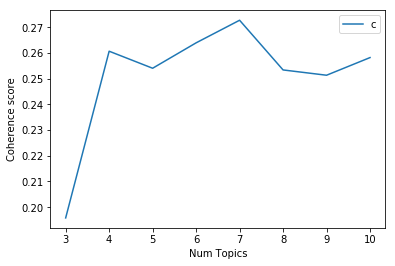

In [256]:
limit=11; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

A partir de la mesure de cohérence entre les différents thèmes on peut voir qu'un nombre de 6 ou 7 thèmes permet de mieux les différencier entre eux. Par rapport au différents thèmes/types de problèmes proposés dans le dataset initial, nous avons décidé de conserver 6 thèmes principaux.

On cherche donc la composition des mots dans nos thèmes sachant que nous avons fixé le nombre de thèmes à 6. Nous itérons 200 fois.

In [250]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=200, workers=5)

In [251]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.060*"delay" + 0.039*"hour" + 0.029*"late" + 0.029*"plane" + 0.026*"time" + 0.022*"wait" + 0.021*"gate" + 0.016*"board" + 0.013*"thank" + 0.012*"sit"
Topic: 1 
Words: 0.056*"miss" + 0.047*"seat" + 0.040*"connect" + 0.020*"delay" + 0.017*"go" + 0.012*"upgrad" + 0.010*"class" + 0.009*"problem" + 0.008*"plane" + 0.007*"happi"
Topic: 2 
Words: 0.095*"cancel" + 0.047*"flightl" + 0.025*"hour" + 0.017*"rebook" + 0.014*"hold" + 0.014*"stuck" + 0.013*"tomorrow" + 0.012*"wait" + 0.010*"home" + 0.010*"help"
Topic: 3 
Words: 0.041*"help" + 0.036*"hold" + 0.028*"phone" + 0.024*"hour" + 0.024*"tri" + 0.023*"book" + 0.020*"chang" + 0.016*"need" + 0.016*"time" + 0.014*"call"
Topic: 4 
Words: 0.073*"servic" + 0.072*"custom" + 0.020*"bad" + 0.019*"agent" + 0.013*"experi" + 0.013*"airlin" + 0.011*"rude" + 0.010*"care" + 0.010*"time" + 0.010*"unit"
Topic: 5 
Words: 0.026*"luggag" + 0.025*"bag" + 0.024*"lose" + 0.019*"baggag" + 0.018*"like" + 0.014*"look" + 0.013*"dont" + 0.011*"need" + 0

On peut donc connaître la proportion des mots dans chacun de nos 6 thèmes.
On représente ci-dessous de manière plus visuelle cette proportion de mots dans nos thèmes.

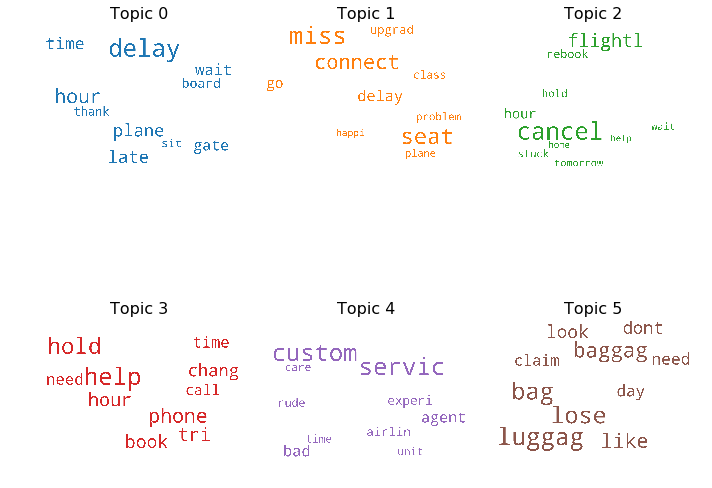

In [252]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

On peut donc établir une correspondance entre nos thèmes supervisé et les thèmes non supervisés relevés avec le topic modeling.

- Topic 0 : Late Flight
- Topic 1 : Bad Flight
- Topic 2 : Cancelled Flight
- Topic 3 : Flight Booking Problems
- Topic 4 : Customer Service Issue
- Topic 5 : Lost Luggage

Pour s'assurer que notre topic modeling est correct, nous pouvons utiliser t-SNE en 2D pour visualiser la séparation des différents thèmes entre eux.

In [253]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7831 samples in 0.003s...
[t-SNE] Computed neighbors for 7831 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7831
[t-SNE] Computed conditional probabilities for sample 2000 / 7831
[t-SNE] Computed conditional probabilities for sample 3000 / 7831
[t-SNE] Computed conditional probabilities for sample 4000 / 7831
[t-SNE] Computed conditional probabilities for sample 5000 / 7831
[t-SNE] Computed conditional probabilities for sample 6000 / 7831
[t-SNE] Computed conditional probabilities for sample 7000 / 7831
[t-SNE] Computed conditional probabilities for sample 7831 / 7831
[t-SNE] Mean sigma: 0.000652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.982113
[t-SNE] KL divergence after 1000 iterations: 0.606520


Loading BokehJS ...

Cependant, la librairie pyLDAvis permet de bien comprendre la séparation des thèmes. Il faut éviter que les bulles de thèmes ne s'entrecoupent.

In [254]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(vis)

Il faut faire attention, les numéros des bulles (ci-dessous) ne correspondent pas avec ceux que nous avons attribué précédemment juste au dessus.

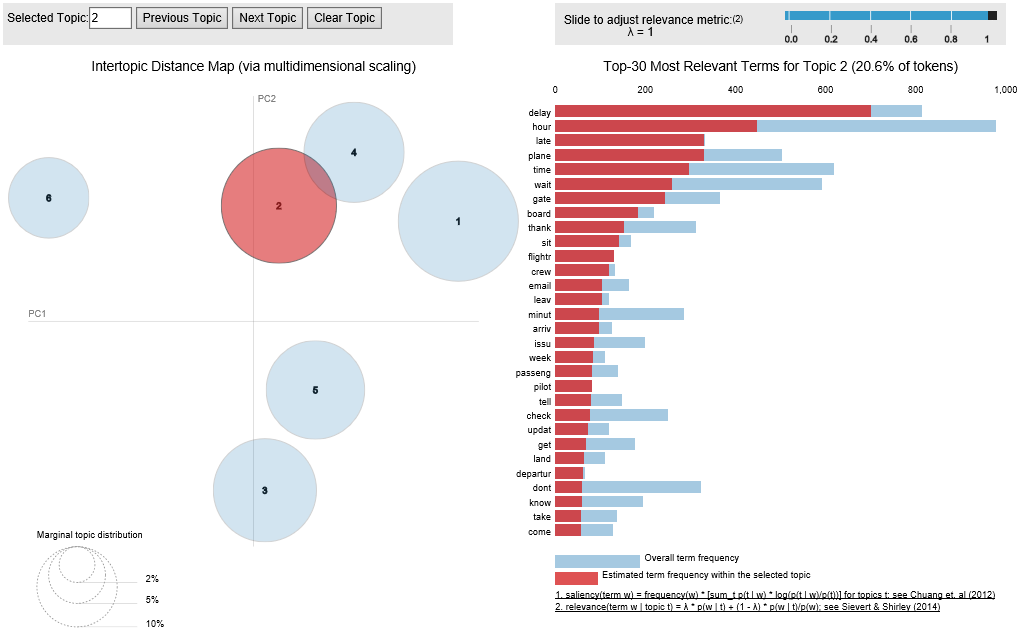

On pourrait également utiliser term frequency document inverse frequency pour faire du topic modeling. Cependant on s'apperçoit que la plupart des mots qui composent les thèmes sont ceux qui reviennent le plus fréquemment dans tous les tweets. Par exemple, delay, cancel, luggage apparaissent très souvent. On va donc apporter moins d'importance aux termes qui reviennent peu souvent.  
Une modélisation bow est donc suffisante.

Nous pouvons également trouver le topic dominant dans chaque tweet et son pourcentage associé

In [257]:
def format_topics_sentences(texts, ldamodel=lda_model, corpus=bow_corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=Tweet_airline['text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6056,"help, hold, phone, hour, tri, book, chang, need, time, call","@USAirways any guesstimate on hold times? Can't change my flight online, at 45 mins and counting..."
1,1,4.0,0.5938,"servic, custom, bad, agent, experi, airlin, rude, care, time, unit",@USAirways unfortunately patience won't get me to my boat that leaves at 4 pm. I was on hold watching all flights fill up.
2,2,0.0,0.4755,"delay, hour, late, plane, time, wait, gate, board, thank, sit",@SouthwestAir okay I understand a delay one way. But both ways? C'mon #annoyed #flights
3,3,3.0,0.6725,"help, hold, phone, hour, tri, book, chang, need, time, call","@USAirways your checkin at @PHLAirport is a #shitshow, and the agent behind the counter who tried to send me to the wrong destination=rude!"
4,4,0.0,0.4671,"delay, hour, late, plane, time, wait, gate, board, thank, sit",@SouthwestAir Why doesn't mean TSA PreCheck show up on my mobile boarding pass? My KTN is linked to my account.
5,5,2.0,0.8605,"cancel, flightl, hour, rebook, hold, stuck, tomorrow, wait, home, help",@united flight was Cancelled Flighted after the last opportunity to rebook us on other flights this evening passed.
6,6,3.0,0.8324,"help, hold, phone, hour, tri, book, chang, need, time, call",@JetBlue WHAT'S UP WITH WEBSITE CAN'T ACCESS FLIGHT INFO
7,7,5.0,0.9163,"luggag, bag, lose, baggag, like, look, dont, need, day, claim",NaN
8,8,0.0,0.9159,"delay, hour, late, plane, time, wait, gate, board, thank, sit",@AmericanAir umm unexpected?? Unexpected meaning you guys didn't know you had a major staff shortage ??
9,9,4.0,0.4951,"servic, custom, bad, agent, experi, airlin, rude, care, time, unit",@AmericanAir the app doesn't allow Canadian address. I used the mobile Canadian site and it will not let you select a passenger.


On va comparer par rapport aux catégories de notre dataset initial.

In [265]:
Tweet_airline['Real_Topic'] = Tweet_airline.negativereason
Tweet_airline.Real_Topic = Tweet_airline.Real_Topic.replace('Late Flight', 0)
Tweet_airline.Real_Topic = Tweet_airline.Real_Topic.replace('Bad Flight', 1)
Tweet_airline.Real_Topic = Tweet_airline.Real_Topic.replace('Cancelled Flight', 2)
Tweet_airline.Real_Topic = Tweet_airline.Real_Topic.replace('Flight Booking Problems', 3)
Tweet_airline.Real_Topic = Tweet_airline.Real_Topic.replace('Customer Service Issue', 4)
Tweet_airline.Real_Topic = Tweet_airline.Real_Topic.replace('Lost Luggage', 5)

In [268]:
Tweet_airline[['text', 'negativereason', 'Real_Topic']].head()

,text,negativereason,Real_Topic
0,"@USAirways any guesstimate on hold times? Can't change my flight online, at 45 mins and counting...",Customer Service Issue,4
1,@USAirways unfortunately patience won't get me to my boat that leaves at 4 pm. I was on hold watching all flights fill up.,Late Flight,0
2,@SouthwestAir okay I understand a delay one way. But both ways? C'mon #annoyed #flights,Late Flight,0
3,"@USAirways your checkin at @PHLAirport is a #shitshow, and the agent behind the counter who tried to send me to the wrong destination=rude!",Flight Attendant Complaints,Flight Attendant Complaints
4,@SouthwestAir Why doesn't mean TSA PreCheck show up on my mobile boarding pass? My KTN is linked to my account.,Flight Booking Problems,3


In [269]:
df1 = Tweet_airline[['text', 'negativereason', 'Real_Topic']]
df2 = df_dominant_topic[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]
Comparison = pd.concat([df1, df2], axis=1, sort=False)

In [272]:
Comparison.head(15)

,text,negativereason,Real_Topic,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,"@USAirways any guesstimate on hold times? Can't change my flight online, at 45 mins and counting...",Customer Service Issue,4,3.0,0.6056,"help, hold, phone, hour, tri, book, chang, need, time, call"
1,@USAirways unfortunately patience won't get me to my boat that leaves at 4 pm. I was on hold watching all flights fill up.,Late Flight,0,4.0,0.5938,"servic, custom, bad, agent, experi, airlin, rude, care, time, unit"
2,@SouthwestAir okay I understand a delay one way. But both ways? C'mon #annoyed #flights,Late Flight,0,0.0,0.4755,"delay, hour, late, plane, time, wait, gate, board, thank, sit"
3,"@USAirways your checkin at @PHLAirport is a #shitshow, and the agent behind the counter who tried to send me to the wrong destination=rude!",Flight Attendant Complaints,Flight Attendant Complaints,3.0,0.6725,"help, hold, phone, hour, tri, book, chang, need, time, call"
4,@SouthwestAir Why doesn't mean TSA PreCheck show up on my mobile boarding pass? My KTN is linked to my account.,Flight Booking Problems,3,0.0,0.4671,"delay, hour, late, plane, time, wait, gate, board, thank, sit"
5,@united flight was Cancelled Flighted after the last opportunity to rebook us on other flights this evening passed.,Cancelled Flight,2,2.0,0.8605,"cancel, flightl, hour, rebook, hold, stuck, tomorrow, wait, home, help"
6,@JetBlue WHAT'S UP WITH WEBSITE CAN'T ACCESS FLIGHT INFO,Flight Booking Problems,3,3.0,0.8324,"help, hold, phone, hour, tri, book, chang, need, time, call"
7,NaN,NaN,NaN,5.0,0.9163,"luggag, bag, lose, baggag, like, look, dont, need, day, claim"
8,@AmericanAir umm unexpected?? Unexpected meaning you guys didn't know you had a major staff shortage ??,Customer Service Issue,4,0.0,0.9159,"delay, hour, late, plane, time, wait, gate, board, thank, sit"
9,@AmericanAir the app doesn't allow Canadian address. I used the mobile Canadian site and it will not let you select a passenger.,Flight Booking Problems,3,4.0,0.4951,"servic, custom, bad, agent, experi, airlin, rude, care, time, unit"


On peut voir que la comparaison n'est pas terrible, cependant cela peut être du aux similarités entre les topics et la mauvaise attribution des noms aux topics.

On peut également sortir les tweets les plus représentatifs de chacun des topics.

In [277]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head(6)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9442,"delay, hour, late, plane, time, wait, gate, board, thank, sit","@AmericanAir Cool, a canned response. Nah, I think I'll keep tweeting at everyone who mentions AA on Twitter. You could DM me, though."
1,1.0,0.9401,"miss, seat, connect, delay, go, upgrad, class, problem, plane, happi",@USAirways Still on hold. 1 hour and 45 minutes and counting. Platinum? Who cares? Problems checking in? Who cares?
2,2.0,0.9400,"cancel, flightl, hour, rebook, hold, stuck, tomorrow, wait, home, help","@united THAT'S the tweet u choose to answer, to tell me you're not liable?! #youretheworst #neveragain"
3,3.0,0.9403,"help, hold, phone, hour, tri, book, chang, need, time, call",@JetBlue managers telling us to write a letter because we're upset about our tickets to leave tomorrow getting Cancelled Flightled without any notice
4,4.0,0.9401,"servic, custom, bad, agent, experi, airlin, rude, care, time, unit",@USAirways is there a better time to call? My flight is on Friday and I need to change it. Worried I may be on hold until then.
5,5.0,0.9397,"luggag, bag, lose, baggag, like, look, dont, need, day, claim",NaN


Et regarder la distribution des thèmes parmis tous les tweets.

In [276]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(6)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"help, hold, phone, hour, tri, book, chang, need, time, call",1804.0,0.2258
1,4.0,"servic, custom, bad, agent, experi, airlin, rude, care, time, unit",620.0,0.0776
2,0.0,"delay, hour, late, plane, time, wait, gate, board, thank, sit",1227.0,0.1536
3,3.0,"help, hold, phone, hour, tri, book, chang, need, time, call",1917.0,0.2400
4,0.0,"delay, hour, late, plane, time, wait, gate, board, thank, sit",1253.0,0.1569
5,2.0,"cancel, flightl, hour, rebook, hold, stuck, tomorrow, wait, home, help",1167.0,0.1461


# Analyse en temps réel 

On utilise la librairie tweepy pour accéder aux tweets en temps réel, textblob pour traduire les tweets en anglais (pour ceux qui ne le sont déja pas).

Déroulement : 
- On requete un mot clé, le code se charge de récolter les tweets contenant ce mot clé en direct 
- On traduit en anglais si nécessaire et on applique les prétraitements classiques sur les tweets 
- On utilise un des modèles (au choix ici cnn_glove) pour prédire le sentiment de chacun des tweets récoltés 

Une extension à cela pourrait être d'associer les sentiments des tweets à un topic modelling (associer les sujets aux sentiments )  par rapport à un mot clé, cela pourrait par exemple aider à décrytper des news autours d'un sujet/ d'une personne / d'une entreprise en tendance sur twitter 

In [201]:
def clean_tweet(tweet):
    dict= {}
    data = {'text': [tweet]}
    df3= pd.DataFrame.from_dict(data)
    df3['clean_text'] = tc.transform(df3['text'])
    df3['tokenized'] = df3['clean_text'].apply(lambda row: tokenize(row))
    df3['tokenized'] = df3['tokenized'].apply(lambda row: remove_stopwords(row))
    df3['tokenized_int'] = df3['tokenized'].apply(lambda x: transform_to_ids(x))
    x = df3['tokenized_int'].loc[0] 
    x= np.array(x)
    x = x.reshape(1,-1)
    x_pad = pad_sequences(x, maxlen=maxlen, value=0)
    
    return x_pad
tweet_int = clean_tweet("salut good and you happy !!!")
print(tweet_int)

np.argmax(cnn_glove.predict(tweet_int), axis= 1)[0]

[[ 0  0  0  0  0  0  0  0  2 53]]


1

In [205]:
cnn_glove.summary()from keras import models
from keras import layers
from keras import optimizers

def transfer_model(pretrained_model ): 
    # Create the model
    model = models.Sequential()

    # Add the first layers of the trained model :keep the output of the k_ième layer 
    # Ici on enlève les 2 dernières couches dense_11 et dense_12
    model.add(Model(inputs=pretrained_model.get_input_at(0) ,outputs=pretrained_model.get_layer("dropout_4").get_output_at(0)))
    #model.add(pretrained_model)  à la place de la ligne du dessus si pas besoin d'enlever les dernières couches 

    # Add new layers
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    
    return model
    
    trans_model = transfer_model(cnn_glove )# avec transfer 
essai = trans_model.fit(x_train_2, hot_y_2, validation_data=(x_valid_2, hot_y_valid_2), epochs=10, batch_size=20)# sans transfer 
cnn_glove1 = mult_conv_glove()
essai2 = cnn_glove1.fit(x_train_2, hot_y_2, validation_data=(x_valid_2, hot_y_valid_2), epochs=10, batch_size=20)
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 

class TwitterClient(object): 

    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''
    def __init__(self):
        
        ''' 
        Class constructor or initialization method. 
        '''
        #Variables that contains the user credentials to access Twitter API 
        access_token = ""
        access_token_secret = ""
        consumer_key = ""
        consumer_secret = ""

        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 

   
    
    def clean_tweet(self,  tweet):
        dict= {}
        data = {'text': [tweet]}
        df3= pd.DataFrame.from_dict(data)
        df3['clean_text'] = tc.transform(df3['text'])
        df3['tokenized'] = df3['clean_text'].apply(lambda row: tokenize(row))
        df3['tokenized'] = df3['tokenized'].apply(lambda row: remove_stopwords(row))
        df3['tokenized_int'] = df3['tokenized'].apply(lambda x: transform_to_ids(x))
        x = df3['tokenized_int'].loc[0] 
        x= np.array(x)
        x = x.reshape(1,-1)
        x_pad = pad_sequences(x, maxlen=maxlen, value=0)

        return x_pad
    
    
    

    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        #analysis = TextBlob(self.clean_tweet(tweet))
        
        # on utilise ici notre modèle cnn_glove (réseau convolutionel avec glove)
        
        tweet_int = self.clean_tweet(tweet)

        analysis = np.argmax(cnn_glove.predict(tweet_int), axis= 1)[0]
        # set sentiment 
        if analysis> 0: 
            return 'positive'
        else:
            return 'negative'

    def get_tweets(self, query, count = 10, traduction =True): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        # empty list to store parsed tweets 
        tweets = [] 

        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count) 

            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {} 

                
                
                # permet de traduire en anglais pour appliquer nos predictions sur des tweet de langues ! = anglais 
                if traduction == True:
                        # saving text of tweet 
                    try :
                        en_blob = TextBlob(tweet.text)
                        translate_tweet = str(en_blob.translate(to='en'))
                        parsed_tweet['text'] = translate_tweet
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(translate_tweet)
                    except : 
                        parsed_tweet['text'] = tweet.text 
                        # saving sentiment of tweet 
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text) 
                        
                else:
                         # saving text of tweet 

                    parsed_tweet['text'] = tweet.text     
                    # saving sentiment of tweet 
                    parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)  
                    

                # appending parsed tweet to tweets list 
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet) 

            # return parsed tweets 
            return tweets 

        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e)) 

def main(): 
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    tweets = api.get_tweets(query = 'trump', count = 200) 

    # picking positive tweets from tweets 
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive'] 
    # percentage of positive tweets 
    print("Positive or neutral tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
    # picking negative tweets from tweets 
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative'] 
    # percentage of negative tweets 
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
   
  

    # printing first 5 negative tweets 
    print("\n\nNegative tweets:") 
    for tweet in ntweets[:10]: 
        print(tweet['text']) 
        
    
    # printing first 5 positive tweets 
    print("\n\nPositive tweets:") 
    for tweet in ptweets[:10]: 
        print(tweet['text']) 

    # printing first 5 neutral tweets 
    print("\n\nNombre de tweets :") 
    print(len(tweets))
    print(tweets[:5])
    
    
if __name__ == "__main__": 
    # calling main function 
    main() 


Positive or neutral tweets percentage: 55.913978494623656 %
Negative tweets percentage: 44.086021505376344 %


Negative tweets:
RT @MaddowBlog: If that quarter billion dollar magic trick Donald Trump tried to play with that financial statement is, in fact, evidence o…
RT @realJeffreyP: Remember, frmr. U.S. Attorney Dennis Burke, my old colleague, was the United States Attorney who resigned in shame during…
RT @leeleeb50: Due to the success of the 5 D's of trump, I thought I should start from the beginning....with A

asshole
asshat
assclown
aby…
RT @sbg1: The bills are coming due for Trump, and if there’s one thing we know about the President it’s that he doesn’t like to pay his bil…
RT @scooze007: @realDonaldTrump You should be worried about the lies you told on security clearances for your family. I would think you are…
@Musicbizfraud @CNN @MichaelCohen212 @realDonaldTrump You have a poor understanding of how politics work.  Trump is… https://t.co/wAvS6C3Zs5
RT @SitterKitty: A person 

## Topic modeling en temps réel sur des tweets d'Airlines

On va maintenant utiliser l'API de twitter pour classifier les tweets négatifs relevés en type de problèmes obtenus avec le Topic Modeling.
On avait donc vu 6 différents thèmes

Sachant que dans notre dataset, les clients s'adressaient à 5 compagnies aériennes différentes:
- @JetBlue
- @united
- @USAAirways
- @SouthwestAir
- @AmericanAir

Nous allons examiner leurs tweets négatifs.

In [278]:
#Variables that contains the user credentials to access Twitter API 
#access_token = "2428582741-AiUAkFWX7BvCJKYrFLoGNPPYHZMpaoD0wovEdPD"
#access_token_secret = "crLKd0Aj8cNL1kSVcoB0VW29IX9w0ntakOIw1hvWVZBeb"
#consumer_key = "AivhKB2gcsqlKrxb4AdWLIvnB"
#consumer_secret = "7pojFqIY4nVULPxVkWZRfbRnvSqDNJMjCI9u5ZE5ctOoJuEi5Q"

In [ ]:
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 

class TwitterClient(object): 

    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''
    def __init__(self):
        
        ''' 
        Class constructor or initialization method. 
        '''
        #Variables that contains the user credentials to access Twitter API 
        access_token = ""
        access_token_secret = ""
        consumer_key = ""
        consumer_secret = ""

        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 

   
    
    def clean_tweet(self,  tweet):
        dict= {}
        data = {'text': [tweet]}
        df3= pd.DataFrame.from_dict(data)
        df3['clean_text'] = tc.transform(df3['text'])
        df3['tokenized'] = df3['clean_text'].apply(lambda row: tokenize(row))
        df3['tokenized'] = df3['tokenized'].apply(lambda row: remove_stopwords(row))
        df3['tokenized_int'] = df3['tokenized'].apply(lambda x: transform_to_ids(x))
        x = df3['tokenized_int'].loc[0] 
        x= np.array(x)
        x = x.reshape(1,-1)
        x_pad = pad_sequences(x, maxlen=maxlen, value=0)

        return x_pad
    
    
    

    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        #analysis = TextBlob(self.clean_tweet(tweet))
        
        # on utilise ici notre modèle cnn_glove (réseau convolutionel avec glove)
        
        tweet_int = self.clean_tweet(tweet)

        analysis = np.argmax(cnn_glove.predict(tweet_int), axis= 1)[0]
        # set sentiment 
        if analysis> 0: 
            return 'positive'
        else:
            return 'negative'

    def get_tweets(self, query, count = 10, traduction =True): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        # empty list to store parsed tweets 
        tweets = [] 

        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count) 

            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {} 

                
                
                # permet de traduire en anglais pour appliquer nos predictions sur des tweet de langues ! = anglais 
                if traduction == True:
                        # saving text of tweet 
                    try :
                        en_blob = TextBlob(tweet.text)
                        translate_tweet = str(en_blob.translate(to='en'))
                        parsed_tweet['text'] = translate_tweet
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(translate_tweet)
                    except : 
                        parsed_tweet['text'] = tweet.text 
                        # saving sentiment of tweet 
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text) 
                        
                else:
                         # saving text of tweet 

                    parsed_tweet['text'] = tweet.text     
                    # saving sentiment of tweet 
                    parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)  
                    

                # appending parsed tweet to tweets list 
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet) 

            # return parsed tweets 
            return tweets 

        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e))

In [356]:
def main(query='US Airways', count=200): 
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    tweets = api.get_tweets(query, count) 

    # picking negative tweets from tweets 
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative'] 
    # percentage of negative tweets 
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
   
  

    # printing first 5 negative tweets 
    print("\n\nNegative tweets:") 
    for tweet in ntweets[:10]: 
        print(tweet['text']) 
        
    return(ntweets)

In [362]:
ntweets = main('@JetBlue',500)

Negative tweets percentage: 57.47126436781609 %


Negative tweets:
RT @ABC7: FLY DEAL: @JetBlue sweepstakes offers chance at year's worth of free flights if you wipe clean your Instagram feed https://t.co/Y…
@glfceo @atulbutte @united @fly2ohare Currently delayed 7 hours on @JetBlue trying to get to Durham
RT @BrooklynNets: Want to follow the Nets to Atlanta this weekend?

Enter our #FlyMeTo Sweepstakes presented by @jetblue here ✈️➡️ https://…
@davidwebbshow Out of curiosity, did @JetBlue replace the cop killer poster at LGA with any other Blacks deserving… https://t.co/UAh8gSjfQT
Hi @JetBlue! I am on flight 1969 BOS-FLL that is delayed by 3 hours this evening. Worried that this flight will get… https://t.co/UUOTjdG67t
@JetBlue I had a flight canceled last week. I got an email confirming some type of credit but I have yet to receive… https://t.co/UUTNL88onf
RT @lily_vasey: @JetBlue is the worst airline ever, never fly them! https://t.co/I1hh0L5MS0
@JetBlue both flights in and out of m

In [363]:
df_ntweets = pd.DataFrame(ntweets)

In [386]:
df_ntweets.head(50)

,sentiment,text
0,negative,RT @ABC7: FLY DEAL: @JetBlue sweepstakes offers chance at year's worth of free flights if you wipe clean your Instagram feed https://t.co/Y…
1,negative,@glfceo @atulbutte @united @fly2ohare Currently delayed 7 hours on @JetBlue trying to get to Durham
2,negative,RT @BrooklynNets: Want to follow the Nets to Atlanta this weekend?\n\nEnter our #FlyMeTo Sweepstakes presented by @jetblue here ✈️➡️ https://…
3,negative,"@davidwebbshow Out of curiosity, did @JetBlue replace the cop killer poster at LGA with any other Blacks deserving… https://t.co/UAh8gSjfQT"
4,negative,Hi @JetBlue! I am on flight 1969 BOS-FLL that is delayed by 3 hours this evening. Worried that this flight will get… https://t.co/UUOTjdG67t
5,negative,@JetBlue I had a flight canceled last week. I got an email confirming some type of credit but I have yet to receive… https://t.co/UUTNL88onf
6,negative,"RT @lily_vasey: @JetBlue is the worst airline ever, never fly them! https://t.co/I1hh0L5MS0"
7,negative,@JetBlue both flights in and out of my honeymoon destination were delayed due to reasons that could have been accom… https://t.co/g72aM1mrUl
8,negative,#SocialMedia 📱✈️ @JetBlue contest dares #Instagram addicts to delete their pics FLY FREE for a year—3 winners to be… https://t.co/aXe9nBiT6Y
9,negative,@JetBlue Pulling an @Amtrak Move!!


In [382]:
L=[7,14,34,42,46]
bow_vectors=[]
unseen_documents=[]
for i in L:
    print(df_ntweets['text'][i], '\n')
    unseen_document = df_ntweets['text'][i]
    unseen_documents.append(unseen_document)
    bow_vector = dictionary.doc2bow(preprocess(unseen_document))
    bow_vectors.append(bow_vector)
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    print('\n')

@JetBlue both flights in and out of my honeymoon destination were delayed due to reasons that could have been accom… https://t.co/g72aM1mrUl 

Score: 0.7204936742782593	 Topic: 0.060*"delay" + 0.039*"hour" + 0.029*"late" + 0.029*"plane" + 0.026*"time"
Score: 0.05653693899512291	 Topic: 0.041*"help" + 0.036*"hold" + 0.028*"phone" + 0.024*"hour" + 0.024*"tri"
Score: 0.05608395114541054	 Topic: 0.073*"servic" + 0.072*"custom" + 0.020*"bad" + 0.019*"agent" + 0.013*"experi"
Score: 0.05572888255119324	 Topic: 0.056*"miss" + 0.047*"seat" + 0.040*"connect" + 0.020*"delay" + 0.017*"go"
Score: 0.05557828024029732	 Topic: 0.026*"luggag" + 0.025*"bag" + 0.024*"lose" + 0.019*"baggag" + 0.018*"like"
Score: 0.055578265339136124	 Topic: 0.095*"cancel" + 0.047*"flightl" + 0.025*"hour" + 0.017*"rebook" + 0.014*"hold"


@JetBlue are you serious that you would cancel my groups flight 30 minutes before departure and then offer no. Acco… https://t.co/PyECYgd5BT 

Score: 0.5415731072425842	 Topic: 0.095*"can

In [385]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_vectors, texts=unseen_documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7204,"delay, hour, late, plane, time, wait, gate, board, thank, sit",@JetBlue both flights in and out of my honeymoon destination were delayed due to reasons that could have been accom… https://t.co/g72aM1mrUl
1,1,2.0,0.5416,"cancel, flightl, hour, rebook, hold, stuck, tomorrow, wait, home, help",@JetBlue are you serious that you would cancel my groups flight 30 minutes before departure and then offer no. Acco… https://t.co/PyECYgd5BT
2,2,0.0,0.7908,"delay, hour, late, plane, time, wait, gate, board, thank, sit",Hey @JetBlue you just sent me two emails at the same time that say my flight from DCA -&gt; BOS is delayed and departi… https://t.co/VrYdOsxD1w
3,3,0.0,0.7257,"delay, hour, late, plane, time, wait, gate, board, thank, sit",Sooo... any flight delay compensation @JetBlue? Been sitting at the gate for over an hour and a half at JFK
4,4,2.0,0.5054,"cancel, flightl, hour, rebook, hold, stuck, tomorrow, wait, home, help",@JetBlue what are my options here? My flight last night was cancelled after a 4 hour delay. I slept in the airport… https://t.co/QjFrCQfNhR


Nous pouvons donc prédire les thèmes dominants pour chacun des tweets négatifs.

# Conclusion

Nous avons ainsi pu faire à la fois de l'analyse de sentiments sur un gros dataset de tweets et faire du transfer learning en appliquant sur un autre dataset : le dataset de tweets de compagnies aériennes. Nous avons également pu utiliser le topic modeling qui nous a permis de relever les différents types de problèmes des tweets de clients sur les compagnies aériennes. Enfin, nous avons utilisé l'API de twitter pour analyser en temps réel les tweets de ces compagnies et faire de l'analyse de sentiments et la catégorisation des tweets négatifs avec le topic modeling.